In [44]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from category_encoders import TargetEncoder
#from yellowbrick.classifier import ConfusionMatrix
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, auc

In [2]:
# Definindo estilo
sb.set_style("darkgrid")

In [8]:
# Importando base de dados
data = pd.read_csv('dados/train.csv')
test = pd.read_csv('dados/test.csv')

## Verificando informações do dataset

In [5]:
data.head().style.background_gradient(cmap = 'viridis')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,nan,S


In [6]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Análisando features

In [5]:
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


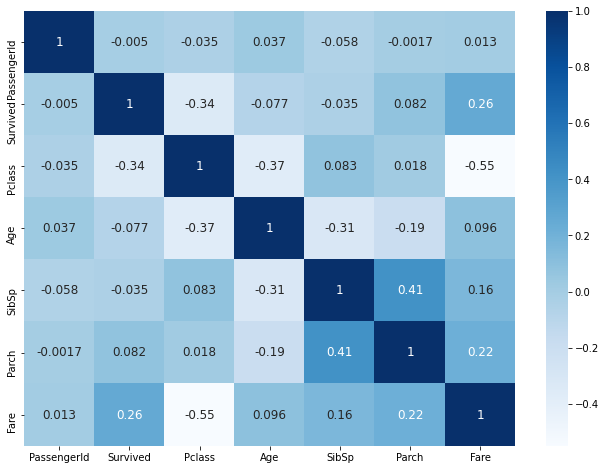

In [18]:
plt.subplots(figsize = (11, 8))
sb.heatmap(data.corr(), annot = True, cmap = 'Blues',  annot_kws = {"size": 12})

In [9]:
data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
data.Sex.value_counts() / data.shape[0] * 100

male      64.758698
female    35.241302
Name: Sex, dtype: float64

In [6]:
data.loc[data.Sex == 'female', 'Survived'].value_counts() / data.shape[0] * 100

1    26.150393
0     9.090909
Name: Survived, dtype: float64

In [12]:
data.loc[data.Sex == 'male', 'Survived'].value_counts() / data.shape[0] * 100

0    52.525253
1    12.233446
Name: Survived, dtype: float64

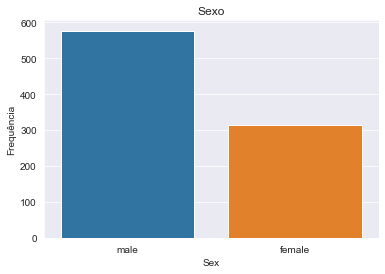

In [13]:
sb.countplot(data.Sex).set_title('Sexo')
plt.xlabel('Sex')
plt.ylabel('Frequência')
plt.show()

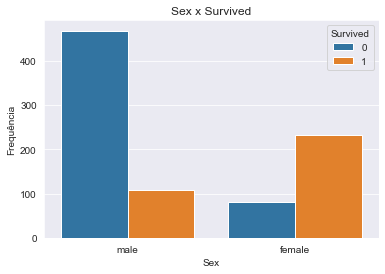

In [14]:
sb.countplot(data.Sex, hue = data.Survived).set_title('Sex x Survived')
plt.xlabel('Sex')
plt.ylabel('Frequência')
plt.show()

In [15]:
data.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [16]:
data.Pclass.value_counts() / data.shape[0] * 100

3    55.106622
1    24.242424
2    20.650954
Name: Pclass, dtype: float64

In [17]:
data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [18]:
data.Embarked.value_counts() / data.shape[0] * 100

S    72.278339
C    18.855219
Q     8.641975
Name: Embarked, dtype: float64

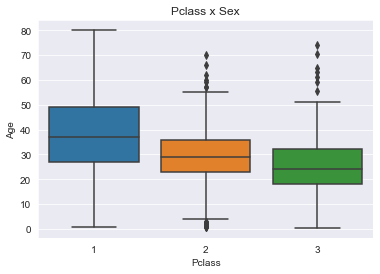

In [11]:
sb.boxplot(x = data.Pclass, y = data.Age).set_title('Pclass x Sex')
plt.show()

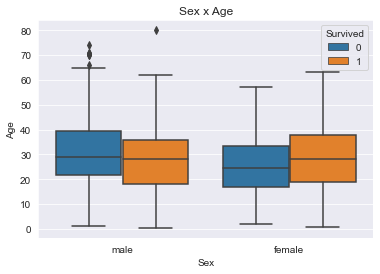

In [12]:
sb.boxplot(x = data.Sex, y = data.Age, hue = data.Survived).set_title('Sex x Age')
plt.show()

## Realisando tratamento dos dados

In [9]:
# Verificando valores nulos
data.isnull().sum().sort_values(ascending = True)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Age            177
Cabin          687
dtype: int64

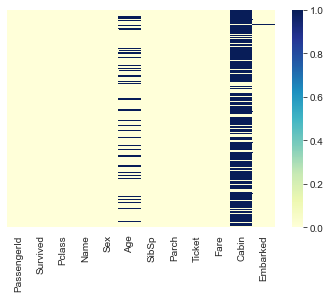

In [10]:
sb.heatmap(data.isnull(), cmap = "YlGnBu", yticklabels = False)

In [11]:
# Retirando dados não relevantes
data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [12]:
# Tratando valores nulos
data.Embarked.describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [13]:
data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [14]:
data['Embarked'].fillna('S', inplace = True)

In [15]:
idadem = data.groupby(['Sex', 'Pclass', 'Embarked', 'Survived']).agg({'Age': 'median'}).values

In [16]:
dados = [data]

for dataset in dados:
    #mean = data['Age'].mean()
    #std = data['Age'].std()
    is_null = dataset['Age'].isnull().sum()
    # Compute random numbers between the mean, std and is_null
    #rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    rand_age = np.random.randint(idadem.min(), idadem.max(), size = is_null)
    # Fill NaN values in Age column with random values generated
    age_slice = dataset['Age'].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset['Age'] = age_slice
    dataset['Age'] = data['Age'].astype(int)

## Categorical encoding

In [17]:
# One-Hot Encoding
data = pd.get_dummies(data)
test = pd.get_dummies(test)

## Separando dados de treino, teste


In [31]:
# Separando features e target
preditos = data.drop('Survived', axis = 1)
classe = data.iloc[:, 0].values

# Dividindo base entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(preditos, classe, test_size = 0.3, random_state = 0)

## Criando Modelo

![Image of Yaktocat](https://media.giphy.com/media/NXp9HM6YeuS0U/giphy.gif)

### Gradient Boostingde

In [32]:
# Criando modelo Gradient Boostingde
modelo = GradientBoostingClassifier()
modelo.fit(X_train, y_train)

# Testando modelo
previsoes = modelo.predict(X_test)

## Avaliando Modelo

In [33]:
ckf = cross_val_score(modelo, preditos, classe, cv = 5, scoring = 'accuracy')
ckf

array([0.80446927, 0.81460674, 0.88764045, 0.82022472, 0.84269663])

In [34]:
# Gerando matriz de confusão
confusao = confusion_matrix(y_test, previsoes)
confusao

array([[154,  14],
       [ 26,  74]])

In [35]:
# Verificando taxa de acerto
taxa_acerto = round(accuracy_score(y_test, previsoes) * 100, 2)
taxa_acerto

85.07

In [36]:
modelo.score(X_train, y_train)

0.8908507223113965

In [37]:
print(classification_report(y_test, previsoes))

precision    recall  f1-score   support

           0       0.86      0.92      0.89       168
           1       0.84      0.74      0.79       100

    accuracy                           0.85       268
   macro avg       0.85      0.83      0.84       268
weighted avg       0.85      0.85      0.85       268



In [38]:
auc_roc = roc_auc_score(y_test, previsoes)
auc_roc

0.8283333333333334

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)
roc_auc

0.8283333333333334

Text(0.5, 0, 'False Positive Rate')

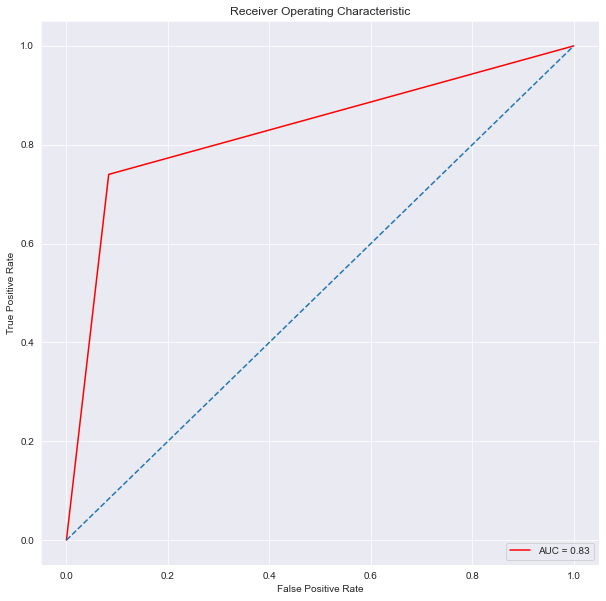

In [41]:
plt.figure(figsize = (10, 10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'red', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Submission

In [ ]:
# Gerando arquivo para envio Kaggle
submission = pd.DataFrame()
submission['PassengerId'] = new_test['PassengerId']
submission['Survived'] = modelo.predict(new_test)
submission.to_csv('submission.csv', index = False)